In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

In [2]:
file_content = pd.read_csv('spam.csv', encoding = "ISO-8859-1")
file_content['spam'] = file_content['v1'].map( {'spam': 1, 'ham': 0} ).astype(int)
dataset = file_content[['v2','spam']]
dataset.columns = ['features', 'target']
dataset.head()

,features,target
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(dataset['features'],dataset['target'],test_size=0.25, stratify=dataset['target'],random_state=100)
MAX_SEQUENCE_LENGTH = 300
MAX_NB_WORDS = 20000
EMB_DIM = 100

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [5]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [6]:
lbl = LabelEncoder()
lbl.fit(y_train)
y_train.shape

(4179,)

In [7]:
y_train = to_categorical(y_train)
y_train.shape

(4179, 2)

In [8]:
y_test = to_categorical(y_test)
y_test.shape

(1393, 2)

In [9]:
X_train = pad_sequences(X_train,maxlen=MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(X_test,maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4179, 300), (1393, 300), (4179, 2), (1393, 2))

# Model Building

# CNN

In [10]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPooling1D(5),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    keras.layers.MaxPooling1D(5),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=2, activation='softmax')
])

In [11]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, batch_size=64 ,epochs=2, validation_data=(X_test,y_test))

Epoch 1/2
66/66 [==============================] - 25s 387ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0888 - val_accuracy: 0.9828
Epoch 2/2
66/66 [==============================] - 22s 328ms/step - loss: 0.0120 - accuracy: 0.9976 - val_loss: 0.0692 - val_accuracy: 0.9842


In [14]:
model_test_acc=model.evaluate(X_test,y_test,batch_size=64)
model_test_acc

22/22 [==============================] - 1s 53ms/step - loss: 0.0692 - accuracy: 0.9842


[0.06915365904569626, 0.9842067360877991]

In [15]:
model_train_acc=model.evaluate(X_train,y_train,batch_size=64)
model_train_acc

66/66 [==============================] - 4s 54ms/step - loss: 0.0111 - accuracy: 0.9995


[0.01114764902740717, 0.9995214343070984]

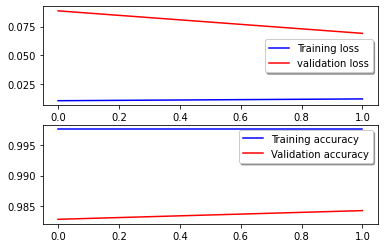

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

# RNN

In [17]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    keras.layers.SimpleRNN(units=2, input_shape=(-1,1)),
    keras.layers.Dense(units=2,activation='softmax')
])

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_test,y_test))

Epoch 1/2
131/131 [==============================] - 22s 145ms/step - loss: 0.2599 - accuracy: 0.9421 - val_loss: 0.1454 - val_accuracy: 0.9821
Epoch 2/2
131/131 [==============================] - 18s 136ms/step - loss: 0.1019 - accuracy: 0.9911 - val_loss: 0.0968 - val_accuracy: 0.9871


# LSTM

In [20]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    keras.layers.LSTM(units=2, activation='relu', return_sequences=True),
    keras.layers.Flatten(),
    keras.layers.Dense(units=2,activation='softmax')
])

In [21]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
history = model.fit(X_train,y_train, batch_size=16, epochs=2, validation_data=(X_test,y_test))

Epoch 1/2
262/262 [==============================] - 50s 182ms/step - loss: 0.2488 - accuracy: 0.9064 - val_loss: 0.0693 - val_accuracy: 0.9835
Epoch 2/2
262/262 [==============================] - 64s 245ms/step - loss: 0.0467 - accuracy: 0.9866 - val_loss: 0.0553 - val_accuracy: 0.9856


In [23]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred.round()))

44/44 [==============================] - 3s 42ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1206
           1       1.00      0.89      0.94       187

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.99      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393
 samples avg       0.99      0.99      0.99      1393



# BiLSTM

In [24]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=MAX_NB_WORDS, output_dim=EMB_DIM, input_length=MAX_SEQUENCE_LENGTH),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=2, activation='softmax')
])

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
history = model.fit(X_train,y_train, batch_size=16, epochs=2, validation_data=(X_test,y_test))

Epoch 1/2
262/262 [==============================] - 110s 392ms/step - loss: 0.1127 - accuracy: 0.9593 - val_loss: 0.0432 - val_accuracy: 0.9878
Epoch 2/2
262/262 [==============================] - 87s 333ms/step - loss: 0.0178 - accuracy: 0.9952 - val_loss: 0.0666 - val_accuracy: 0.9864


In [27]:
y_pred = model.predict(X_test)
print(classification_report(y_test,y_pred.round()))

44/44 [==============================] - 6s 101ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1206
           1       0.99      0.90      0.95       187

   micro avg       0.99      0.99      0.99      1393
   macro avg       0.99      0.95      0.97      1393
weighted avg       0.99      0.99      0.99      1393
 samples avg       0.99      0.99      0.99      1393

